According to the Modern Portfolio Theory, the efficient frontier is a set of optimal portfolios in the
risk-return spectrum.
This means that the portfolios on the frontier:

• Offer the highest expected return for a given level of risk

• Offer the lowest level of risk for a given level of expected returns

In [ ]:
# In this recipe, we show how to find the efficient frontier using Monte Carlo simulations
# we employ a brute force approach in which we build thousands of portfolios using randomly assigned weights
# Then, we can calculate the portfolios’ performance (expected returns/volatility) and use those values to determine the efficient frontier

# For this exercise, we use the returns of four US tech companies from 2021

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

In [5]:
# Set up the parameters:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252 # considered timeframe

ASSETS = ["META", "TSLA", "X", "MSFT"]
ASSETS.sort() # to sort the list alphabetically (due to yfinance)

n_assets = len(ASSETS)

In [ ]:
prices_df = yf.download(ASSETS,
 start="2021-01-01",
 end="2021-12-31",
 auto_adjust=True)

In [8]:
# Calculate the annualized average returns and the corresponding standard deviation:
returns_df = prices_df["Close"].pct_change().dropna() # dropping first row as usuaò
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

# we needed the average (expected) annual return and the corresponding covariance matrix.
# We obtained them by using the mean and cov methods
# We also annualized both metrics by multiplying them by 252 (the average number of trading days in a year)

In [9]:
# Simulate random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

Following the assumptions of the modern portfolio theory (refer to the chapter introduction for reference), the weights needed to be positive and
sum up to 1. To achieve this, we first generated a matrix of random numbers (between 0 and 1) using
np.random.random. The matrix was of size N_SIMULATIONS by n_assets. To make sure the weights
summed up to 1, we divided each row of the matrix by its sum.

In [15]:
# Calculate the portfolio metrics:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []

for i in range(0, len(weights)):
 vol = np.sqrt(
 np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
 )
 portf_vol.append(vol)

portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol
# For this example, we assumed that the risk-free rate was 0%, so the Sharpe ratio of the portfolio could
# be calculated as portfolio returns divided by the portfolio’s volatility.

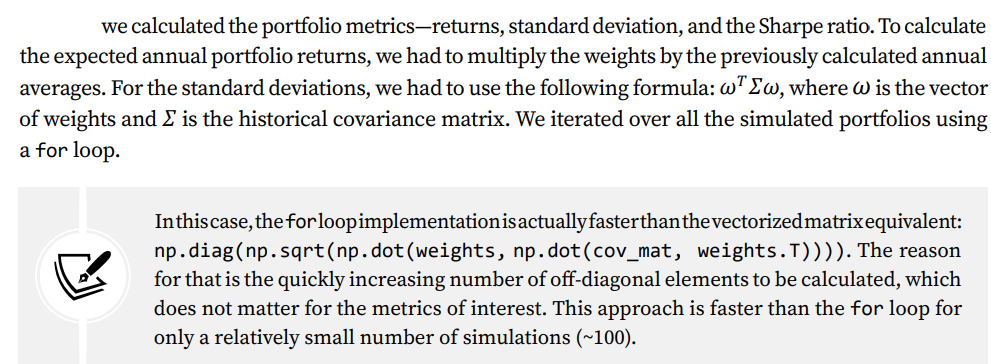

In [ ]:
# DATA VISUALIZATION

In [16]:
# Create a DataFrame containing all the data:
portf_results_df = pd.DataFrame(
 {"returns": portf_rtns,
 "volatility": portf_vol,
 "sharpe_ratio": portf_sharpe_ratio}
)

In [18]:
portf_results_df.head()

,returns,volatility,sharpe_ratio
0,0.477285,0.274668,1.737679
1,0.487945,0.468664,1.041141
2,0.448574,0.301141,1.489582
3,0.381575,0.245815,1.552287
4,0.465591,0.266873,1.744611


In [19]:
# Locate the points creating the efficient frontier:
N_POINTS = 100

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(portf_results_df["returns"].min(),
 portf_results_df["returns"].max(),
 N_POINTS)

possible_ef_rtns = np.round(possible_ef_rtns, 2)
portf_rtns = np.round(portf_rtns, 2)


for rtn in possible_ef_rtns:
  if rtn in portf_rtns:
    ef_rtn_list.append(rtn)
    matched_ind = np.where(portf_rtns == rtn)
    ef_vol_list.append(np.min(portf_vol[matched_ind]))

# we created an array of expected returns from the sample.
# We used np.linspace, with the min and max values coming from the calculated portfolio returns
# We rounded the numbers to two decimals to make the calculations smoother.
# For each expected return, we found the minimum observed volatility. In cases where there
# was no match, as can happen with equally spread points on the linear space, we skipped that point.

In [20]:
import matplotlib.pyplot as plt

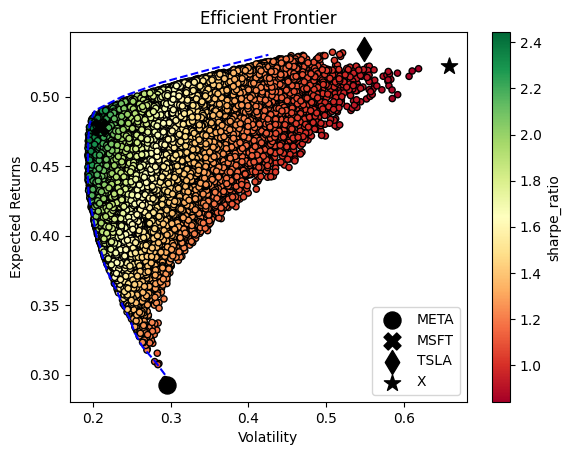

In [21]:
# Plot the efficient frontier:
MARKERS = ["o", "X", "d", "*"]

fig, ax = plt.subplots()

portf_results_df.plot(kind="scatter", x="volatility",
 y="returns", c="sharpe_ratio",
 cmap="RdYlGn", edgecolors="black",
 ax=ax)

ax.set(xlabel="Volatility",
 ylabel="Expected Returns",
 title="Efficient Frontier")

ax.plot(ef_vol_list, ef_rtn_list, "b--")


for asset_index in range(n_assets):
  ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
  y=avg_returns[asset_index],
  marker=MARKERS[asset_index],
  s=150, color="black",
  label=ASSETS[asset_index])

ax.legend()
plt.show()

# we plotted the simulated portfolios, the individual assets, and the approximated efficient frontier in one plot.
# Additionally, we colored the dots representing the simulated portfolios by the value of the Sharpe ratio.

# Following the ratio’s definition, the upper-left part of the plot shows a sweet spot with the highest expected returns per expected volatility.

In [ ]:
# Anything to the left of the efficient frontier’s line is not achievable, as we cannot get that level
# of expected return for such a level of volatility.

# The performance of a portfolio consisting only of Microsoft’s stock lies very close to the efficient frontier

Having simulated 100,000 random portfolios, we can also investigate which one has the highest Sharpe
ratio (maximum expected return per unit of risk, also known as the tangency portfolio) or minimum
volatility. To locate these portfolios among the simulated ones, we use the np.argmin and np.argmax
functions, which return the index of the minimum/maximum value in the array.

In [24]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df["volatility"])
min_vol_portf = portf_results_df.loc[min_vol_ind]

print(max_sharpe_portf)
print("\n")
print(min_vol_portf)

returns         0.478078
volatility      0.195583
sharpe_ratio    2.444379
Name: 88377, dtype: float64


returns         0.444525
volatility      0.193682
sharpe_ratio    2.295126
Name: 58978, dtype: float64
